# Volcanic Impact on Ocean Buoyancy Fluxes

This notebook analyzes the impact of volcanic forcing on ocean buoyancy fluxes by comparing:
- Volcanic vs non-volcanic ensemble simulations
- Different time periods (7701-7705, 7706-7715, 7716-7720)  
- Seasonal patterns (DJF winter and JJA summer)
- Buoyancy flux components (total, haline, thermal)

The final output generates two key figures:
- **Figure 4**: DJF (winter) buoyancy flux anomalies [Volcanism - No Volcanism]
- **Figure 5**: JJA (summer) buoyancy flux anomalies [Volcanism - No Volcanism]

In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec
import cmocean as ocm
from xclim import ensembles
import gsw
#import seawater
import xesmf as xe
import cftime
import nc_time_axis
import dask, distributed
from dask.distributed import Client


## 1. Import Required Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
SSS_volc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230iveq500tg7701e0??_ocn_SSS.nc'), use_cftime=True).squeeze()
SSS_novolc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230ivnoeq500tg7701e0??_ocn_SSS.nc'), use_cftime=True).squeeze()
SST_volc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230iveq500tg7701e0??_ocn_SST.nc'), use_cftime=True).squeeze()
SST_novolc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230ivnoeq500tg7701e0??_ocn_SST.nc'), use_cftime=True).squeeze()
SHF_volc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230iveq500tg7701e0??_ocn_SHF.nc'), use_cftime=True).squeeze()
SHF_novolc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230ivnoeq500tg7701e0??_ocn_SHF.nc'), use_cftime=True).squeeze()
SFWF_volc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230iveq500tg7701e0??_ocn_SFWF.nc'), use_cftime=True).squeeze()
SFWF_novolc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230ivnoeq500tg7701e0??_ocn_SFWF.nc'), use_cftime=True).squeeze()


## 2. Load Ensemble Data

Load volcanic and non-volcanic ensemble data for:
- Sea Surface Salinity (SSS)
- Sea Surface Temperature (SST) 
- Surface Heat Flux (SHF)
- Surface Freshwater Flux (SFWF)

In [3]:
# Calculate ensemble means for volcanic runs
SSS_volc_ensmean = SSS_volc.mean(dim='realization').compute()
SST_volc_ensmean = SST_volc.mean(dim='realization').compute()
SHF_volc_ensmean = SHF_volc.mean(dim='realization').compute()
SFWF_volc_ensmean = SFWF_volc.mean(dim='realization').compute()


## 3. Calculate Ensemble Means

In [4]:
# Calculate ensemble means for non-volcanic runs  
SSS_novolc_ensmean = SSS_novolc.mean(dim='realization').compute()
SST_novolc_ensmean = SST_novolc.mean(dim='realization').compute()
SHF_novolc_ensmean = SHF_novolc.mean(dim='realization').compute()
SFWF_novolc_ensmean = SFWF_novolc.mean(dim='realization').compute()


In [5]:
## Reference Coordinate
#ts_ref     = xr.open_dataset('/mdata/erda/RJH/modeldata/TS/eq500tg7701_ens/cesmi6gat31rblc230iveq500tg7701e000_atm_TS.nc')
#time_ref   = ts_ref.time
#lon, lat   = ts_ref.lon, ts_ref.lat
lon, lat   = np.linspace(-180,180,361), np.linspace(-90,90,181)
nlon, nlat = len(lon), len(lat)
constfile = xr.open_dataset('/scratch/climo/cesmi6gat31rblc200/ocn/hist/ts/cesmi6gat31rblc200_ANN_210912_998911_pop_decclimots.nc')

grav = constfile["grav"]
cp_sw = constfile["cp_sw"]
rho_sw = constfile["rho_sw"]
dz = constfile["dz"]



## 4. Setup Grid and Load Constants

In [6]:
def Regridder(var, lon_in, lat_in, lon_out, lat_out, varreg):
    ### Regridding
    grid_in  =      {'lon': lon_in,  'lat': lat_in}           # (nlat, nlon) = (384,320)
    grid_out =      {'lon': lon_out, 'lat': lat_out}          # (nlat, nlon) = (192, 288)
    regridder=      xe.Regridder(grid_in, grid_out, 'bilinear', periodic=True)
    var_reg  = regridder(var)
    if varreg:
        var_reg  = var_reg.where(var_reg!=0.)
    return var_reg


In [7]:
# Regrid volcanic ensemble means
SSS_volc_ensmean_rg = Regridder(SSS_volc_ensmean, SSS_volc_ensmean.TLONG, SSS_volc_ensmean.TLAT, lon, lat, True)
SST_volc_ensmean_rg = Regridder(SST_volc_ensmean, SST_volc_ensmean.TLONG, SST_volc_ensmean.TLAT, lon, lat, True)
SHF_volc_ensmean_rg = Regridder(SHF_volc_ensmean, SHF_volc_ensmean.TLONG, SHF_volc_ensmean.TLAT, lon, lat, True)
SFWF_volc_ensmean_rg = Regridder(SFWF_volc_ensmean, SFWF_volc_ensmean.TLONG, SFWF_volc_ensmean.TLAT, lon, lat, True)

# Regrid non-volcanic ensemble means 
SSS_novolc_ensmean_rg = Regridder(SSS_novolc_ensmean, SSS_novolc_ensmean.TLONG, SSS_novolc_ensmean.TLAT, lon, lat, True)
SST_novolc_ensmean_rg = Regridder(SST_novolc_ensmean, SST_novolc_ensmean.TLONG, SST_novolc_ensmean.TLAT, lon, lat, True)
SHF_novolc_ensmean_rg = Regridder(SHF_novolc_ensmean, SHF_novolc_ensmean.TLONG, SHF_novolc_ensmean.TLAT, lon, lat, True)
SFWF_novolc_ensmean_rg = Regridder(SFWF_novolc_ensmean, SFWF_novolc_ensmean.TLONG, SFWF_novolc_ensmean.TLAT, lon, lat, True)


## 5. Regrid Data to Common Grid

In [8]:
# Define winter and summer seasons 
winter_months = [12, 1, 2]  # DJF
summer_months = [6, 7, 8]   # JJA

# Create seasonal time series for volcanic runs
SSS_volc_winter_ts = SSS_volc_ensmean_rg.sel(time=SSS_volc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()
SST_volc_winter_ts = SST_volc_ensmean_rg.sel(time=SST_volc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()
SHF_volc_winter_ts = SHF_volc_ensmean_rg.sel(time=SHF_volc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()
SFWF_volc_winter_ts = SFWF_volc_ensmean_rg.sel(time=SFWF_volc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()

SSS_volc_summer_ts = SSS_volc_ensmean_rg.sel(time=SSS_volc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()
SST_volc_summer_ts = SST_volc_ensmean_rg.sel(time=SST_volc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()
SHF_volc_summer_ts = SHF_volc_ensmean_rg.sel(time=SHF_volc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()
SFWF_volc_summer_ts = SFWF_volc_ensmean_rg.sel(time=SFWF_volc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()

SSS_volc_annual_ts = SSS_volc_ensmean_rg.groupby('time.year').mean()
SST_volc_annual_ts = SST_volc_ensmean_rg.groupby('time.year').mean()
SHF_volc_annual_ts = SHF_volc_ensmean_rg.groupby('time.year').mean()
SFWF_volc_annual_ts = SFWF_volc_ensmean_rg.groupby('time.year').mean()

# Create seasonal time series for non-volcanic runs
SSS_novolc_winter_ts = SSS_novolc_ensmean_rg.sel(time=SSS_novolc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()
SST_novolc_winter_ts = SST_novolc_ensmean_rg.sel(time=SST_novolc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()
SHF_novolc_winter_ts = SHF_novolc_ensmean_rg.sel(time=SHF_novolc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()
SFWF_novolc_winter_ts = SFWF_novolc_ensmean_rg.sel(time=SFWF_novolc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()

SSS_novolc_summer_ts = SSS_novolc_ensmean_rg.sel(time=SSS_novolc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()
SST_novolc_summer_ts = SST_novolc_ensmean_rg.sel(time=SST_novolc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()
SHF_novolc_summer_ts = SHF_novolc_ensmean_rg.sel(time=SHF_novolc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()
SFWF_novolc_summer_ts = SFWF_novolc_ensmean_rg.sel(time=SFWF_novolc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()

SSS_novolc_annual_ts = SSS_novolc_ensmean_rg.groupby('time.year').mean()
SST_novolc_annual_ts = SST_novolc_ensmean_rg.groupby('time.year').mean()
SHF_novolc_annual_ts = SHF_novolc_ensmean_rg.groupby('time.year').mean()
SFWF_novolc_annual_ts = SFWF_novolc_ensmean_rg.groupby('time.year').mean()


## 6. Create Seasonal Time Series

Extract seasonal (DJF, JJA) and annual averages for each variable.

In [9]:
plt_years = [[7701,7705], [7706,7715], [7716,7720]]

# Function to split data into periods and calculate means
def split_periods_mean(data, periods):
    return [data.sel(year=slice(p[0], p[1])).mean('year') for p in periods]

# Split and average volcanic winter periods
SSS_volc_winter_periods = split_periods_mean(SSS_volc_winter_ts, plt_years)  
SST_volc_winter_periods = split_periods_mean(SST_volc_winter_ts, plt_years)
SHF_volc_winter_periods = split_periods_mean(SHF_volc_winter_ts, plt_years)
SFWF_volc_winter_periods = split_periods_mean(SFWF_volc_winter_ts, plt_years)

# Split and average volcanic summer periods 
SSS_volc_summer_periods = split_periods_mean(SSS_volc_summer_ts, plt_years)
SST_volc_summer_periods = split_periods_mean(SST_volc_summer_ts, plt_years) 
SHF_volc_summer_periods = split_periods_mean(SHF_volc_summer_ts, plt_years)
SFWF_volc_summer_periods = split_periods_mean(SFWF_volc_summer_ts, plt_years)

# Split and average volcanic summer periods 
SSS_volc_annual_periods = split_periods_mean(SSS_volc_annual_ts, plt_years)
SST_volc_annual_periods = split_periods_mean(SST_volc_annual_ts, plt_years) 
SHF_volc_annual_periods = split_periods_mean(SHF_volc_annual_ts, plt_years)
SFWF_volc_annual_periods = split_periods_mean(SFWF_volc_annual_ts, plt_years)


# Split and average non-volcanic winter periods
SSS_novolc_winter_periods = split_periods_mean(SSS_novolc_winter_ts, plt_years)
SST_novolc_winter_periods = split_periods_mean(SST_novolc_winter_ts, plt_years)
SHF_novolc_winter_periods = split_periods_mean(SHF_novolc_winter_ts, plt_years) 
SFWF_novolc_winter_periods = split_periods_mean(SFWF_novolc_winter_ts, plt_years)

# Split and average non-volcanic summer periods
SSS_novolc_summer_periods = split_periods_mean(SSS_novolc_summer_ts, plt_years)
SST_novolc_summer_periods = split_periods_mean(SST_novolc_summer_ts, plt_years)
SHF_novolc_summer_periods = split_periods_mean(SHF_novolc_summer_ts, plt_years)
SFWF_novolc_summer_periods = split_periods_mean(SFWF_novolc_summer_ts, plt_years)

# Split and average non-volcanic annual periods
SSS_novolc_annual_periods = split_periods_mean(SSS_novolc_annual_ts, plt_years)
SST_novolc_annual_periods = split_periods_mean(SST_novolc_annual_ts, plt_years)
SHF_novolc_annual_periods = split_periods_mean(SHF_novolc_annual_ts, plt_years)
SFWF_novolc_annual_periods = split_periods_mean(SFWF_novolc_annual_ts, plt_years)


## 7. Average Data Over Time Periods

Split data into three analysis periods and calculate means:
- Period 1: Years 7701-7705 (immediate response)
- Period 2: Years 7706-7715 (medium-term response)  
- Period 3: Years 7716-7720 (longer-term response)

In [10]:

def combine_period_datasets(*var_periods):
    # First concatenate each variable's periods into single DataArray
    period_arrays = [xr.concat(var_period, dim='period') for var_period in var_periods]
    # Then merge all variables together
    return xr.merge(period_arrays)

# Combine all period types 
volc_winter_periods = combine_period_datasets(
    SSS_volc_winter_periods,
    SST_volc_winter_periods, 
    SHF_volc_winter_periods,
    SFWF_volc_winter_periods
)

volc_summer_periods = combine_period_datasets(
    SSS_volc_summer_periods,
    SST_volc_summer_periods,
    SHF_volc_summer_periods, 
    SFWF_volc_summer_periods
)

volc_annual_periods = combine_period_datasets(
    SSS_volc_annual_periods,
    SST_volc_annual_periods,
    SHF_volc_annual_periods, 
    SFWF_volc_annual_periods
)

novolc_winter_periods = combine_period_datasets(
    SSS_novolc_winter_periods,
    SST_novolc_winter_periods,
    SHF_novolc_winter_periods,
    SFWF_novolc_winter_periods
)

novolc_summer_periods = combine_period_datasets(
    SSS_novolc_summer_periods, 
    SST_novolc_summer_periods,
    SHF_novolc_summer_periods,
    SFWF_novolc_summer_periods
)

novolc_annual_periods = combine_period_datasets(
    SSS_novolc_annual_periods, 
    SST_novolc_annual_periods,
    SHF_novolc_annual_periods,
    SFWF_novolc_annual_periods
)


In [11]:
# lets look at buouancy fluxes
# Calculate buoancy vs latitude
# Make sure units are correct
# alpha=[1/K] sst=[deg C] sss=[g/kg]
def buoyancy_flux(grav, rho_sw, cp_sw, shf, sfwf, sss, sst, p=0.0):
    alpha = gsw.alpha(sss, sst, p) # alpha > 0
    beta = gsw.beta(sss, sst, p) #beta > 0
    #    B0=grav*(1.0e-5*beta*sfwf*sss - 1.0e-1*(alpha/(rho_sw*cp_sw))*shf) # m^2/s^3
    #print(alpha)
    # the haline fwf adds buoyancy to the surface when > 0
    # beta > 0 , so buoyancy is added to ocean surface when B_haline > 0 
    hal_const = grav.data * 1.0e-5 * beta
    haline = hal_const * sfwf * sss
    # for the thermal if SHF > 0 then heat is added to ocean surface (more buoyant , eg. in the tropics)
    therm_const = grav.data * 1.0e-1 * (alpha / (rho_sw.data * cp_sw.data))
    thermal = therm_const * shf

    B0 = (
        haline + thermal
    )  # m^2/s^3 (+ve thermal adds buoyancy to surface; +ve haline adds buoyancy to surfacve)

    return B0 * 1.0e6, haline * 1.0e6, thermal * 1.0e6, alpha, beta  # mm^2/s^3

## 8. Calculate Buoyancy Fluxes

Buoyancy flux combines thermal and haline components:
- **Thermal component**: driven by surface heat flux and thermal expansion coefficient  
- **Haline component**: driven by freshwater flux and haline contraction coefficient
- **Total buoyancy flux**: B₀ = B_thermal + B_haline

In [12]:
def calculate_buoyancy_fluxes(data):
    
    # Calculate buoyancy fluxes for period 1
    b_flux_1, haline_1, thermal_1, alpha_1, beta_1 = buoyancy_flux(
        grav, rho_sw, cp_sw,
        data['SHF'].isel(period=0), data['SFWF'].isel(period=0),
        data['SSS'].isel(period=0), data['SST'].isel(period=0)
    )

    # Calculate buoyancy fluxes for period 2
    b_flux_2, haline_2, thermal_2, alpha_2, beta_2 = buoyancy_flux(
        grav, rho_sw, cp_sw,
        data['SHF'].isel(period=1), data['SFWF'].isel(period=1),
        data['SSS'].isel(period=1), data['SST'].isel(period=1)
    )

    # Calculate buoyancy fluxes for period 3  
    b_flux_3, haline_3, thermal_3, alpha_3, beta_3 = buoyancy_flux(
        grav, rho_sw, cp_sw,
        data['SHF'].isel(period=2), data['SFWF'].isel(period=2),
        data['SSS'].isel(period=2), data['SST'].isel(period=2)
    )

    # Store results in dictionaries for easy access
    buoyancy_fluxes = {
        'period1': {'total': b_flux_1, 'haline': haline_1, 'thermal': thermal_1, 'alpha': alpha_1, 'beta': beta_1},
        'period2': {'total': b_flux_2, 'haline': haline_2, 'thermal': thermal_2, 'alpha': alpha_2, 'beta': beta_2},
        'period3': {'total': b_flux_3, 'haline': haline_3, 'thermal': thermal_3, 'alpha': alpha_3, 'beta': beta_3}
    }

    
    return buoyancy_fluxes

# Calculate buoyancy fluxes for all periods
volc_winter_periods_bflux = calculate_buoyancy_fluxes(volc_winter_periods)
novolc_winter_periods_bflux = calculate_buoyancy_fluxes(novolc_winter_periods)
volc_summer_periods_bflux = calculate_buoyancy_fluxes(volc_summer_periods)
novolc_summer_periods_bflux = calculate_buoyancy_fluxes(novolc_summer_periods)
volc_annual_periods_bflux = calculate_buoyancy_fluxes(volc_annual_periods)
novolc_annual_periods_bflux = calculate_buoyancy_fluxes(novolc_annual_periods)


## Final Figures: Seasonal Buoyancy Flux Anomalies

The following two cells generate the final figures showing buoyancy flux anomalies (volcanic - non-volcanic experiments) for different time periods and components:

- **Total Buoyancy Flux**: Combined thermal and haline contributions
- **Haline Component**: Salinity-driven buoyancy changes  
- **Thermal Component**: Temperature-driven buoyancy changes

Each figure shows three time periods:
- Years 7701-7705 (immediate post-volcanic)
- Years 7706-7715 (medium-term response) 
- Years 7716-7720 (longer-term response)

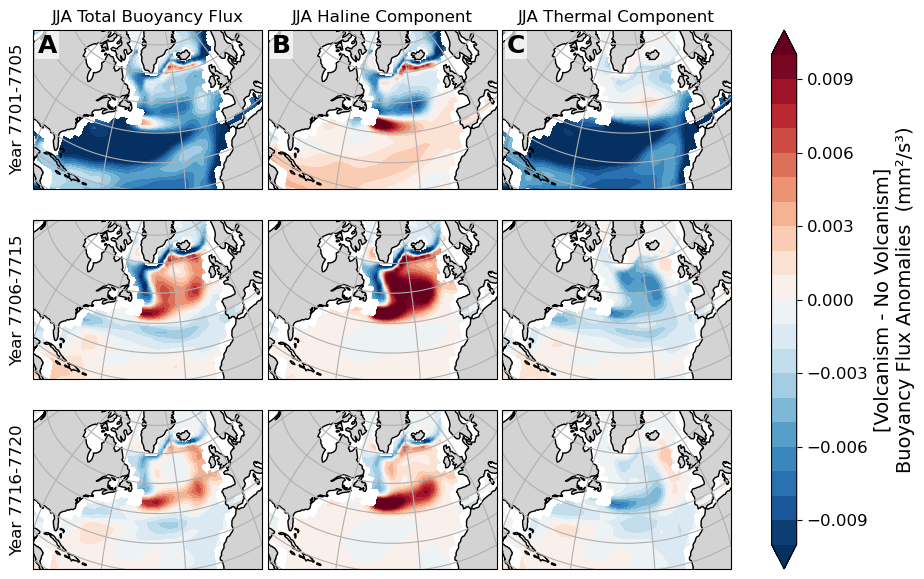

In [13]:
# FIGURE 5: JJA (Summer) Buoyancy Flux Anomalies
# Creates a 3x3 plot showing [Volcanism - No Volcanism] buoyancy flux anomalies
# for JJA season across three time periods and three components

def create_buoyancy_plots(seasons_data, anomaly=False):
    fig = plt.figure(figsize=(10, 7))
    gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 0.25, 0.1], height_ratios=[1, 1, 1])

    titles = ['Total Buoyancy Flux', 'Haline Component', 'Thermal Component']
    periods = ['period1', 'period2', 'period3']
    years = ['7701-7705', '7706-7715', '7716-7720']
    components = ['total', 'haline', 'thermal']
    labels = ['A', 'B', 'C']

    proj = ccrs.Orthographic(central_longitude=-40, central_latitude=45)

    season_name = 'JJA'
    season_data = seasons_data[season_name]
        
    for row, period in enumerate(periods):
        for col, component in enumerate(components):
            ax = plt.subplot(gs[row, col], projection=proj)
            
            if anomaly:
                data = (season_data['volc'][period][component] - 
                       season_data['novolc'][period][component])
            else:
                data = season_data['volc'][period][component]
                
            im = ax.contourf(data.lon, data.lat, data,
                            levels=np.linspace(-0.01, 0.01, 21) if anomaly else np.linspace(-0.1, 0.1, 21),
                            transform=ccrs.PlateCarree(),
                            extend='both',
                            cmap='RdBu_r')
            
            ax.coastlines()
            ax.add_feature(cfeature.LAND, color='lightgray')
            ax.set_extent([-90, 0, 20, 70], ccrs.PlateCarree())
            ax.gridlines()
            
            if row == 0:
                ax.set_title(f'{season_name} {titles[col]}')
                ax.text(0.02, 0.98, labels[col], transform=ax.transAxes,
                       fontsize=18, fontweight='bold', va='top',
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1.5))
            if col == 0:
                ax.text(-0.1, 0.5, f'Year {years[row]}',
                       transform=ax.transAxes, rotation=90,
                       verticalalignment='center', size=12)

    # Single colorbar on right side that spans all plots
    cbar_ax = plt.subplot(gs[:, -1])
    label = f'{"[Volcanism - No Volcanism]\nBuoyancy Flux Anomalies " if anomaly else "Volcanism Experiment Buoyancy Flux"} (mm²/s³)'
    cbar = plt.colorbar(im, cax=cbar_ax, label=label, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label, size=14)

    plt.subplots_adjust(wspace=-0.1, hspace=0.2)
    return fig

# Dictionary with seasonal data
seasons_data = {
    'DJF': {'volc': volc_winter_periods_bflux, 'novolc': novolc_winter_periods_bflux},
    'JJA': {'volc': volc_summer_periods_bflux, 'novolc': novolc_summer_periods_bflux}
}

# Create JJA (summer) anomaly plot 
fig = create_buoyancy_plots(seasons_data, anomaly=True)
icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(icepaperdir+"Figure5_SA.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure5_SA.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

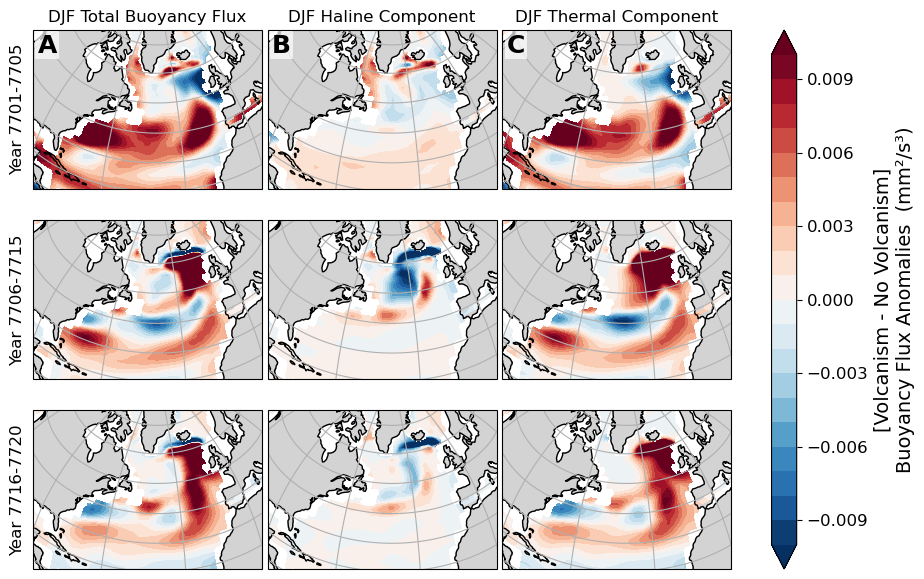

In [14]:
# FIGURE 4: DJF (Winter) Buoyancy Flux Anomalies  
# Creates a 3x3 plot showing [Volcanism - No Volcanism] buoyancy flux anomalies
# for DJF season across three time periods and three components

def create_buoyancy_plots(seasons_data, anomaly=False):
    fig = plt.figure(figsize=(10, 7))
    gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 0.25, 0.1], height_ratios=[1, 1, 1])

    titles = ['Total Buoyancy Flux', 'Haline Component', 'Thermal Component']
    periods = ['period1', 'period2', 'period3']
    years = ['7701-7705', '7706-7715', '7716-7720']
    components = ['total', 'haline', 'thermal']
    labels = ['A', 'B', 'C']

    proj = ccrs.Orthographic(central_longitude=-40, central_latitude=45)

    season_name = 'DJF'
    season_data = seasons_data[season_name]
        
    for row, period in enumerate(periods):
        for col, component in enumerate(components):
            ax = plt.subplot(gs[row, col], projection=proj)
            
            if anomaly:
                data = (season_data['volc'][period][component] - 
                       season_data['novolc'][period][component])
            else:
                data = season_data['volc'][period][component]
                
            im = ax.contourf(data.lon, data.lat, data,
                            levels=np.linspace(-0.01, 0.01, 21) if anomaly else np.linspace(-0.1, 0.1, 21),
                            transform=ccrs.PlateCarree(),
                            extend='both',
                            cmap='RdBu_r')
            
            ax.coastlines()
            ax.add_feature(cfeature.LAND, color='lightgray')
            ax.set_extent([-90, 0, 20, 70], ccrs.PlateCarree())
            ax.gridlines()
            
            if row == 0:
                ax.set_title(f'{season_name} {titles[col]}')
                ax.text(0.02, 0.98, labels[col], transform=ax.transAxes,
                       fontsize=18, fontweight='bold', va='top',
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1.5))
            if col == 0:
                ax.text(-0.1, 0.5, f'Year {years[row]}',
                       transform=ax.transAxes, rotation=90,
                       verticalalignment='center', size=12)

    # Single colorbar on right side that spans all plots
    cbar_ax = plt.subplot(gs[:, -1])
    label = f'{"[Volcanism - No Volcanism]\nBuoyancy Flux Anomalies " if anomaly else "Volcanism Experiment Buoyancy Flux"} (mm²/s³)'
    cbar = plt.colorbar(im, cax=cbar_ax, label=label, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label, size=14)

    plt.subplots_adjust(wspace=-0.1, hspace=0.2)
    return fig

# Dictionary with seasonal data
seasons_data = {
    'DJF': {'volc': volc_winter_periods_bflux, 'novolc': novolc_winter_periods_bflux},
    'JJA': {'volc': volc_summer_periods_bflux, 'novolc': novolc_summer_periods_bflux}
}

# Create DJF (winter) anomaly plot
fig = create_buoyancy_plots(seasons_data, anomaly=True)
icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(icepaperdir+"Figure4_SA.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure4_SA.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)